# Stone Classifier

### Packge Load

In [1]:
import os
import cv2 as cv
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm

from tensorflow.keras import models, layers, losses, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications import VGG16, VGG19, Xception, InceptionResNetV2, InceptionV3
from tensorflow.keras.applications import MobileNet, MobileNetV2, NASNetLarge, NASNetMobile
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
model_dict = {
    "vgg16": VGG16, 
    "vgg19": VGG19,
    "resnet50": ResNet50,
    "resnet101": ResNet101,
    "resnet152": ResNet152,
    "resnet50v2": ResNet50V2,
    "resnet101v2": ResNet101V2,
    "resnet152v2": ResNet152V2,
    "densenet121": DenseNet121,
    "densenet169": DenseNet169,
    "densenet201": DenseNet201,
    "mobilenet": MobileNet,
    "mobilenetv2": MobileNetV2,
    "xception": Xception,
    "inceptionresnetv2": InceptionResNetV2,
    "inceptionv3": InceptionV3, 
    "nasnetlarge": NASNetLarge,
    "nasnetmobile": NASNetMobile,
    "efficientnetb0": EfficientNetB0,
    "efficientnetb1": EfficientNetB1,
    "efficientnetb2": EfficientNetB2,
    "efficientnetb3": EfficientNetB3,
    "efficientnetb4": EfficientNetB4,
    "efficientnetb5": EfficientNetB5,
    "efficientnetb6": EfficientNetB6,
    "efficientnetb7": EfficientNetB7,
}

tf.random.set_seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Prepare Dataset

In [2]:
train_generator = ImageDataGenerator(rescale=1/255.)
valid_generator = ImageDataGenerator(rescale=1/255.)

IMG_SIZE = 224

train_loader = train_generator.flow_from_directory('./data/Train', target_size=(IMG_SIZE,IMG_SIZE), 
                                                 classes=['etc', 'chalcopyrite'],
                                                 class_mode='binary', shuffle=True, 
                                                )
print(f"학습용 황동석 이미지 수: {(train_loader.labels==1).sum()}")
print(f"학습용 황동석 아닌 이미지 수: {(train_loader.labels==0).sum()}\n")

valid_loader = valid_generator.flow_from_directory('./data/Test', target_size=(IMG_SIZE,IMG_SIZE), 
                                                 classes=['etc', 'chalcopyrite'],
                                                 class_mode='binary'
                                                )
print(f"검증용 황동석 이미지 수: {(valid_loader.labels==1).sum()}")
print(f"검증용 황동석 아닌 이미지 수: {(valid_loader.labels==0).sum()}")

Found 1697 images belonging to 2 classes.
학습용 황동석 이미지 수: 712
학습용 황동석 아닌 이미지 수: 985

Found 210 images belonging to 2 classes.
검증용 황동석 이미지 수: 79
검증용 황동석 아닌 이미지 수: 131


### Build Network

In [7]:
model_name = 'vgg16'
base_model = model_dict[model_name](weights="imagenet", pooling="avg", include_top=False)
base_model.trainable = False
dropout = layers.Dropout(0.5)(base_model.output)
output = layers.Dense(1, activation='sigmoid')(dropout)
model = models.Model(base_model.inputs, output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

### Train Model

In [8]:
history = model.fit(train_loader, epochs=20, validation_data=valid_loader)


Epoch 1/20
54/54 [==============================] - 33s 608ms/step - loss: 0.6530 - acc: 0.6064 - val_loss: 0.5062 - val_acc: 0.9095
Epoch 2/20
54/54 [==============================] - 5s 92ms/step - loss: 0.4699 - acc: 0.8161 - val_loss: 0.3935 - val_acc: 0.9190
Epoch 3/20
54/54 [==============================] - 5s 93ms/step - loss: 0.3517 - acc: 0.9322 - val_loss: 0.3206 - val_acc: 0.9571
Epoch 4/20
54/54 [==============================] - 5s 89ms/step - loss: 0.2889 - acc: 0.9570 - val_loss: 0.2786 - val_acc: 0.9286
Epoch 5/20
54/54 [==============================] - 5s 90ms/step - loss: 0.2393 - acc: 0.9676 - val_loss: 0.2400 - val_acc: 0.9571
Epoch 6/20
54/54 [==============================] - 5s 90ms/step - loss: 0.2129 - acc: 0.9670 - val_loss: 0.2172 - val_acc: 0.9571
Epoch 7/20
54/54 [==============================] - 5s 90ms/step - loss: 0.1909 - acc: 0.9699 - val_loss: 0.1976 - val_acc: 0.9571
Epoch 8/20
54/54 [==============================] - 5s 90ms/step - loss: 0.1719 -

In [9]:
model.save(f'./checkpoints/{model_name}.h5')

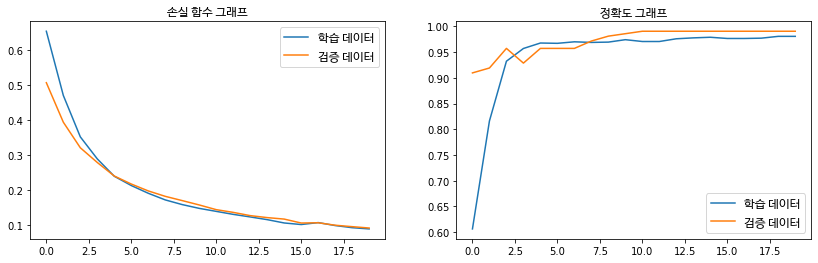

In [10]:
path = './fonts/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=path, size=12)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['학습 데이터', '검증 데이터'], loc=0, prop=fontprop)
plt.title("손실 함수 그래프", fontproperties=fontprop)

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['학습 데이터', '검증 데이터'], loc=0,  prop=fontprop)
plt.title("정확도 그래프", fontproperties=fontprop)

plt.savefig(f"./figures/{model_name}_training_graph.jpg")
plt.show()